In [1]:
import tensorflow as tf
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


testGraph = tf.Graph()
with testGraph.as_default():

    # Make 2 data points in NumPy.
    x_data = np.float32([[1,0]])
    y_data = np.float32([0,1])

    # Construct a linear model.
    b = tf.Variable(np.float32([-1]))
    W = tf.Variable(np.float32([[4]]))

    y = tf.sigmoid(tf.matmul(W, x_data) + b)

    # Minimize the squared errors.
    loss = tf.reduce_mean(tf.square(y - y_data))
    optimizer = tf.train.GradientDescentOptimizer(50.0)
    train = optimizer.minimize(loss)

    tf.summary.scalar(loss.op.name, loss)
    merged_summary_op = tf.summary.merge_all()
    
    # For initializing the variables.
    init = tf.global_variables_initializer()

weight_history = dict(W=[], b=[], loss=[])

# Launch the graph
with tf.Session(graph=testGraph) as sess:
    sess.run(init)

    ([[W_value]], [b_value], loss_value) = sess.run([W, b, loss])
    print('Before training:')
    print(f'W: {W_value:.5f}, b: {b_value:.5f}, loss: {loss_value:.5f}')
    
    summary_writer = tf.summary.FileWriter('/tmp/tensorflow/logs', graph=sess.graph, flush_secs=0.1)
    
    # Training
    for step in range(1, 13):
        sess.run(train)
        if step % 1 == 0:
            ([[W_value]], [b_value], loss_value) = sess.run([W, b, loss])
            weight_history['W'].append(W_value)
            weight_history['b'].append(b_value)
            weight_history['loss'].append(loss_value)
            print(f'step: {step}, W: {W_value:.5f}, b: {b_value:.5f}, loss: {loss_value:.5f}')

            # get summary values
            summary_str = sess.run(merged_summary_op)
            # add sumamary to disk
            summary_writer.add_summary(summary_str,step)

    # Model validating
    result = sess.run(y)[0]

    for i, value in enumerate(x_data[0]):
        print('Tensor raw input: ', value)
        print('Tensor inverted ouput: ', result[i])

        if round(value) == (not round(result[i])):
            print('Tensor aproximately calculate NOT function')
        else:
            print('Tensor does not calculate NOT function')


Before training:
W: 4.00000, b: -1.00000, loss: 0.72092
step: 1, W: 1.84829, b: 4.03504, loss: 0.49738
step: 2, W: 1.71018, b: 3.91176, loss: 0.49659
step: 3, W: 1.53125, b: 3.75168, loss: 0.49522
step: 4, W: 1.28120, b: 3.52734, loss: 0.49235
step: 5, W: 0.88304, b: 3.16876, loss: 0.48387
step: 6, W: 0.05732, b: 2.42119, loss: 0.42894
step: 7, W: -3.23602, b: -0.56660, loss: 0.20375
step: 8, W: -3.25932, b: 6.77754, loss: 0.47162
step: 9, W: -4.61749, b: 5.41944, loss: 0.23833
step: 10, W: -11.99608, b: -1.95819, loss: 0.38398
step: 11, W: -11.99608, b: 2.79026, loss: 0.00167
step: 12, W: -11.99609, b: 2.94792, loss: 0.00124
Tensor raw input:  1.0
Tensor inverted ouput:  0.00011759311
Tensor aproximately calculate NOT function
Tensor raw input:  0.0
Tensor inverted ouput:  0.9501653
Tensor aproximately calculate NOT function


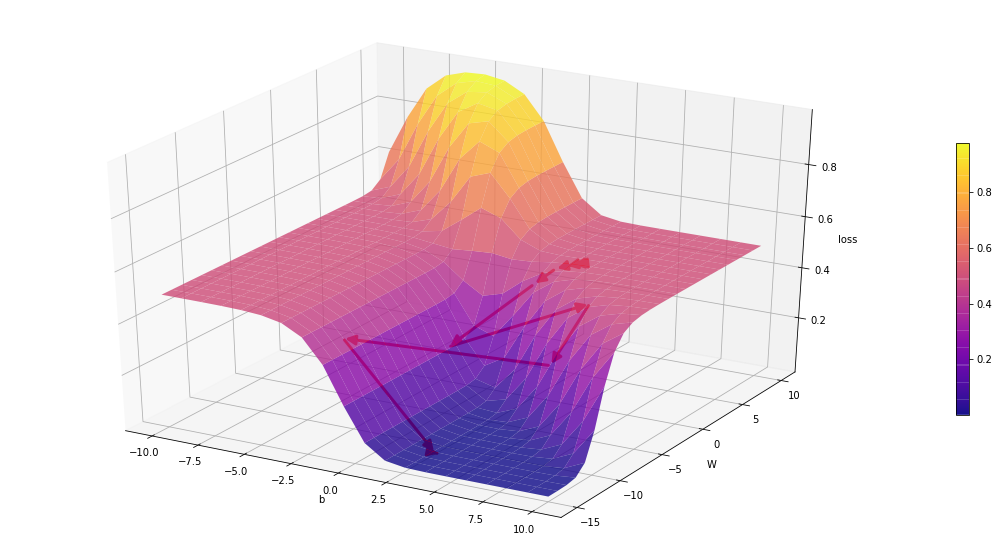

In [2]:
b_min, b_max = (-10, 10)
W_min, W_max = (-15, 10)
b_point_count, W_point_count = (b_max - b_min, W_max - W_min)
b_grid, W_grid = np.meshgrid(np.linspace(b_min, b_max, b_point_count),
                              np.linspace(W_min, W_max, W_point_count))

loss_grid = np.zeros((W_point_count, b_point_count))

with tf.Session(graph=testGraph) as sess:
    sess.run(init)
    for b_index in range(b_point_count):
        for W_index in range(W_point_count):
            b_value = b_grid[W_index][b_index]
            W_value = W_grid[W_index][b_index]
            loss_value = sess.run(loss,
                                  feed_dict={b: [b_value],
                                             W: [[W_value]]})
            loss_grid[W_index][b_index] = loss_value

fig = plt.figure(figsize=(20,10))


# surface_plot with color grading and color bar
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.gca(projection='3d')

ax.set_xlabel('b')
ax.set_ylabel('W')
ax.set_zlabel('loss')

p = ax.plot_surface(b_grid, W_grid, loss_grid,
                    rstride=1, cstride=1, cmap=plt.get_cmap('plasma'),
                    linewidth=0, antialiased=True, alpha=.8)
cb = fig.colorbar(p, shrink=0.5)


# 3D arrow drawing taken from http://stackoverflow.com/a/22867877
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# show update progress
for i in range(1, 12):
    a = Arrow3D(weight_history['b'][i-1:i+1],
                weight_history['W'][i-1:i+1],
                weight_history['loss'][i-1:i+1],
                mutation_scale=20,
                lw=3,
                arrowstyle="-|>",
                color="r")
    ax.add_artist(a)

plt.show()